# Importing

In [69]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn_som.som import SOM
import salishsea_tools.viz_tools as sa_vi


# Datasets Preparation

In [70]:
def datasets_preparation():
    
    ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_grid_T.nc')
    ds_bio = xr. open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_biol_T.nc')

    # Variable selection
    temp = ds.votemper
    saline = ds.vosaline
    date = pd.DatetimeIndex(ds['time_counter'].values)

    # Biological variables
    sil = ds_bio.silicon
    flag = ds_bio.flagellates
    diat = ds_bio.diatoms

    # Open the mesh mask
    mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
    mask = mesh.tmask.to_numpy()
    
    return (ds, temp, saline, date, mask, sil, flag, diat)


# Masking

In [71]:
def masking (depth, temp, saline, mask, sil, flag, diat):

    temp = temp.where(mask[0,depth]==1)
    saline = saline.where(mask[0,depth]==1)

    sil = sil.where(mask[0,depth]==1)
    flag = flag.where(mask[0,depth]==1)
    diat = diat.where(mask[0,depth]==1)

    return (temp, saline, sil, flag, diat)

# SOM

In [72]:
def som (depth, temp, saline):
    
    # Post processing 
    inputs = np.stack((temp[0,depth].values.flatten(), saline[0,depth].values.flatten()))
    indx = np.argwhere(~np.isnan(inputs[0]) & ~np.isnan(inputs[1])) 
    inputs2 = np.transpose(inputs)  
    inputs2 = inputs2[indx[:,0]]

    # SOM
    temp_som = SOM(m=2, n=3, dim= inputs2[0,:].size)
    temp_som.fit(inputs2)
    predictions = temp_som.predict(inputs2)

    # Post processing
    unique, counts = np.unique(predictions, return_counts=True)
    indx2 = np.full(inputs[0,:].size,np.nan)
    indx2[indx[:,0]] = predictions
    clusters = np.reshape(indx2,(898,398))   

    return (unique, counts, inputs2, predictions, clusters)


# Printing

In [73]:
def printing (inputs, predictions, unique, counts):

    # Preparation of the dataframe
    d = {'temperature': inputs[:,0], 'salinity': inputs[:,1], 'cluster': predictions}
    df = pd.DataFrame(d) 

    # Calculating the metrics
    mean_temp = np.round(df.groupby('cluster')['temperature'].mean(), 2)
    mean_sal = np.round(df.groupby('cluster')['salinity'].mean(), 2)
    min_temp = np.round(df.groupby('cluster')['temperature'].min(), 2)
    max_temp = np.round(df.groupby('cluster')['temperature'].max(), 2)
    min_sal = np.round(df.groupby('cluster')['salinity'].min(), 2)
    max_sal = np.round(df.groupby('cluster')['salinity'].max(), 2)

    # Printing
    for i in unique:
            print('The amount of grid boxes for cluster ' + str(i), 'is ' + str(counts[i]), '\n')

            print ('The minimum temperature for cluster '+ str(i), 'is ' + str(min_temp[i]), 'degrees Celsius')
            print ('The maximum temperature for cluster '+ str(i), 'is ' + str(max_temp[i]), 'degrees Celsius')
            print ('The mean temperature for cluster '+ str(i), 'is ' + str(mean_temp[i]), 'degrees Celsius', '\n')

            print ('The minimum salinity for cluster '+ str(i), 'is ' + str(min_sal[i]), 'g/kg')
            print ('The maximum salinity for cluster '+ str(i), 'is ' + str(max_sal[i]), 'g/kg')
            print ('The mean salinity for cluster '+ str(i), 'is ' + str(mean_sal[i]), 'g/kg', '\n'*2)
        

# Plotting

In [74]:
def plotting (depth, clusters, unique):

    # Preparation of the dataarray 
    map = xr.DataArray(clusters,
                    coords = {'y': temp[0,depth].y, 'x': temp[0,depth].x},
                    dims = ['y','x'],
                    attrs=dict(description="Clusters of the performed self organizing map algorithm",
                                long_name ="Cluster",
                                units="count"),
                    ) 

    fig, ax = plt.subplots(1, 1, figsize=(5, 9))
    
    cmap = plt.get_cmap('viridis', int(unique.max()+1))
    cmap.set_bad('gray')

    map.plot.pcolormesh(ax=ax, cmap=cmap, levels= np.concatenate((unique,[6])), cbar_kwargs={'ticks': unique}) 
    sa_vi.set_aspect(ax)
    ax.title.set_text('Depth: ' + str(np.round(ds['deptht'][depth].values,2)) + ' meters')
    fig.suptitle('SOM clustering using temperature and salinity for ' + str(date[0].year) + '/' + str(date[0].month) + '/' + str(date[0].day))
    plt.show()


# Main FOR Loop From Where All Functions are Called

The amount of grid boxes for cluster 0 is 8069 

The minimum temperature for cluster 0 is 7.38 degrees Celsius
The maximum temperature for cluster 0 is 10.58 degrees Celsius
The mean temperature for cluster 0 is 9.2 degrees Celsius 

The minimum salinity for cluster 0 is 23.68 g/kg
The maximum salinity for cluster 0 is 25.64 g/kg
The mean salinity for cluster 0 is 24.72 g/kg 


The amount of grid boxes for cluster 1 is 8867 

The minimum temperature for cluster 1 is 7.5 degrees Celsius
The maximum temperature for cluster 1 is 9.75 degrees Celsius
The mean temperature for cluster 1 is 8.74 degrees Celsius 

The minimum salinity for cluster 1 is 26.75 g/kg
The maximum salinity for cluster 1 is 28.05 g/kg
The mean salinity for cluster 1 is 27.44 g/kg 


The amount of grid boxes for cluster 2 is 27708 

The minimum temperature for cluster 2 is 6.81 degrees Celsius
The maximum temperature for cluster 2 is 9.73 degrees Celsius
The mean temperature for cluster 2 is 8.01 degrees Celsius 

The 

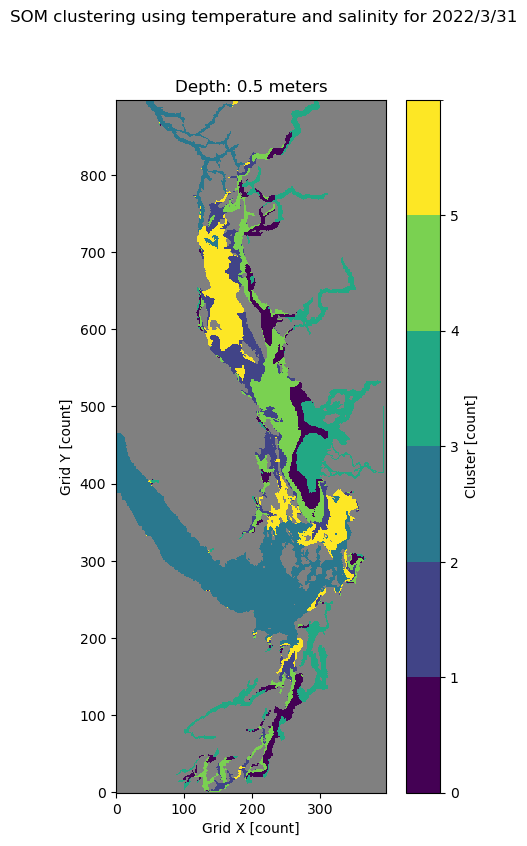

The amount of grid boxes for cluster 0 is 7456 

The minimum temperature for cluster 0 is 7.26 degrees Celsius
The maximum temperature for cluster 0 is 10.64 degrees Celsius
The mean temperature for cluster 0 is 9.13 degrees Celsius 

The minimum salinity for cluster 0 is 22.0 g/kg
The maximum salinity for cluster 0 is 25.13 g/kg
The mean salinity for cluster 0 is 23.84 g/kg 


The amount of grid boxes for cluster 1 is 15807 

The minimum temperature for cluster 1 is 8.15 degrees Celsius
The maximum temperature for cluster 1 is 10.49 degrees Celsius
The mean temperature for cluster 1 is 9.02 degrees Celsius 

The minimum salinity for cluster 1 is 24.95 g/kg
The maximum salinity for cluster 1 is 27.77 g/kg
The mean salinity for cluster 1 is 26.24 g/kg 


The amount of grid boxes for cluster 2 is 16280 

The minimum temperature for cluster 2 is 7.33 degrees Celsius
The maximum temperature for cluster 2 is 10.0 degrees Celsius
The mean temperature for cluster 2 is 8.53 degrees Celsius 

T

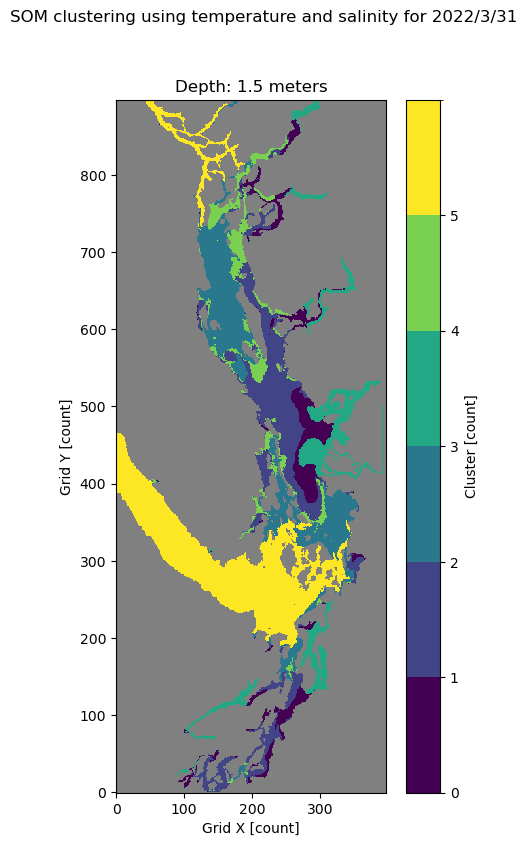

KeyboardInterrupt: 

In [75]:
ds, temp, saline, date, mask, sil, flag, diat = datasets_preparation()

for depth in range (0, ds['deptht'].size+1):

    temp, saline, sil, flag, diat = masking(depth, temp, saline, mask, sil, flag, diat)
    unique, counts, inputs, predictions, clusters = som(depth, temp, saline)
    printing(inputs, predictions, unique, counts)
    plotting (depth, clusters, unique)
